### CHO Kinetics Model Showcase

/var/folders/7m/z4zzcyjd7bqdqcv5y_z08b640000gn/T/ipykernel_90890/2066766767.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(reactor_colors[scale])  # Get color map


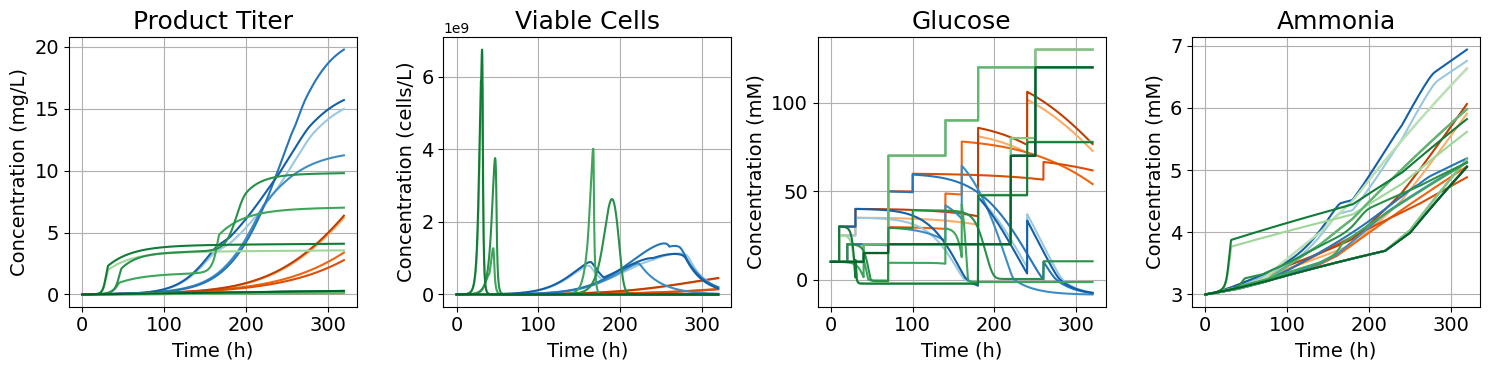

In [ ]:
import matplotlib.pyplot as plt

import mfbo4bio.virtual_lab as vl


def plot_solutions(experiments, only_product=True, title="Experiment Results"):
    """
    Plots each component of the solution vector over time for multiple experiments.

    Parameters
    ----------
    experiments : dict
        A dictionary where keys are reactor types ("MTP", "MBR", "PILOT") and 
        values are lists of EXPERIMENT instances.
    only_product : bool, optional
        If True, only the product concentration ("Product Titer") is plotted. 
        Otherwise, "Product Titer", "Viable Cells", "Glucose", 
        and "Ammonia" are plotted. Defaults to True.
    title : str, optional
        The title for the overall plot. Defaults to "Experiment Results".

    Raises
    ------
    ValueError
        If the `experiments` dictionary is empty or 
        if an experiment's solution is not available.
    """
    if not experiments:
        raise ValueError("No experiments provided.")
    
    all_variables = ["Product Titer", "X_T", "Viable Cells", 
                     "X_D", "Glucose", "Q", "L", "Ammonia"]
    #variables = ["P"] if only_product else all_variables
    variables = ["Product Titer", "Viable Cells", "Glucose", "Ammonia"]
    variable_indices = {var: all_variables.index(var) for var in variables}

    reactor_colors = {
        "MTP": "Oranges",
        "MBR": "Blues",
        "PILOT": "Greens"
    }

    alias = {"MTP": "mtp 1x bolus", "MBR": "ambr", "PILOT": "20L"}

    num_vars = len(variables)
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))
    axes = axes.flatten() if num_vars > 1 else [axes]

    handles = []
    
    for i, var_name in enumerate(variables):
        ax = axes[i]
        
        for scale, exp_list in experiments.items():
            cmap = plt.cm.get_cmap(reactor_colors[scale])  # Get color map
            num_experiments = len(exp_list)

            for j, exp in enumerate(exp_list):
                if exp.solution is None:
                    raise ValueError(f"Experiment {j} solution is not available. \
                                     Run ODE_solver() first.")
                
                color = cmap(0.3 + 0.6 * j / max(1, num_experiments - 1))
                t = exp.t
                values = exp.solution[variable_indices[var_name]]

                line, = ax.plot(t, values, 
                                label=f"{alias[scale]} (Cond {j+1})", color=color)
                if i == 0:
                    handles.append(line)

        units = {"Product Titer": "mg/L", 
                 "Viable Cells": "cells/L", 
                 "Glucose": "mM", 
                 "Ammonia": "mM"}
        
        ax.set_xlabel("Time (h)", fontsize=14)
        ax.set_ylabel(f"Concentration ({units[var_name]})", fontsize=14)
        ax.set_title(f"{var_name}", fontsize=18)
        ax.tick_params(axis="both", labelsize=14)
        ax.grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle(title, fontsize=12, fontweight="bold", ha="right")
    plt.savefig(fname="plots/dynamics_plot_clones.pdf")
    plt.show()

# Define reactor scales and initial conditions
scales = ["MTP", "MBR", "PILOT"]
temp = 30
pH = 6

initial_conditions_list = [

    [31.8, 7.7, [(40, 10) ,(70, 50), (140, 20), (180, 30)],
     "celltype_6", [0, 1.5e7, 1e6, 0, 10,  2,   0, 3]],

    [33, 6.8, [(10, 15) ,(30, 10), (180, 50), (240, 30)],
     "celltype_20", [0, 1.5e7, 1e6, 0, 10,  2,   0, 3]],

    [36, 7.3, [(40, 5) ,(70, 5), (220, 60), (250, 50)],
     "celltype_27", [0, 1.5e7, 1e6, 0, 10,  2,   0, 3]],

    [31.8, 7.7, [(40, 10) ,(70, 50), (140, 20), (180, 30)],
     "celltype_4", [0, 1.5e7, 1e6, 0, 10,  2,   0, 3]],

    [34.4, 7.3, [(40, 10) ,(70, 10), (140, 20), (160, 30)],
     "celltype_1", [0, 1.5e7, 1e6, 0, 10,  2,   0, 3]],

    [38, 7.3, [(20, 10) ,(70, 30), (100, 10), (260, 10)],
     "celltype_9", [0, 1.5e7, 1e6, 0, 10,  2,   0, 3]],

    [33, 6.8, [(10, 20) ,(30, 10), (180, 50), (240, 30)],
     "celltype_20", [0, 1.5e7, 1e6, 0, 10,  2,   0, 3]],
     
    [36, 7.3, [(40, 5) ,(70, 5), (220, 50), (250, 50)],
     "celltype_27", [0, 1.5e7, 1e6, 0, 10,  2,   0, 3]],
    
]

experiments = {scale: [] for scale in scales}

for scale in scales:
    for T, pH, feeding, cell_type, conditions in initial_conditions_list:

        ex = vl.EXPERIMENT(T, pH, cell_type=cell_type, reactor=scale, 
                            feeding=feeding, time=320, clone_distribution="beta")
        ex.initial_conditions = conditions
        ex.ODE_solver(model=scale)
        experiments[scale].append(ex)

# Generate the single combined plot
plot_solutions(experiments, only_product=False,title="")
